In [1]:
import torch
from transformers import FlaubertModel, FlaubertTokenizer, FlaubertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np
import random
from confmat import plot_confusion_matrix

### Charger un modèle Flaubert pré-entrainé 

On utilise la classe FlaubertForSequenceClassification afin de l'utiliser pour de la classification

On enregistre le modèle sur le disque afin de ne pas avoir à le retélécharger

In [36]:
classifier = FlaubertForSequenceClassification.from_pretrained('flaubert/flaubert_base_cased')

In [37]:
classifier.save_pretrained("models/flaubert_pretrained_classification_model")

### Charger le modèle depuis le disque

In [2]:
tok_dir = 'models/flaubert_pretrained_tokenizer'
class_dir = 'models/flaubert_pretrained_classification_model'

In [3]:
tokenizer = FlaubertTokenizer.from_pretrained(tok_dir, do_lowercase=False)
classifier = FlaubertForSequenceClassification.from_pretrained(class_dir)

### Charger les données

In [4]:
data_hate = pd.read_pickle("data_hate.pkl")

In [5]:
tweets = list(data_hate['tweet'])
labels = list(data_hate['sentiment'])

### Équilibrer le jeu de données à la hache

In [6]:
nlist = []
hlist = []
for m, lab in zip(tweets, labels):
    if (lab == 1):
        hlist.append((m, 1))
    else:
        nlist.append((m, 0))

In [7]:
hsample = random.Random(0).sample(hlist, len(nlist))

In [8]:
balanced_dataset = hsample + nlist
random.Random(0).shuffle(balanced_dataset)

In [9]:
btweets = []
blabels = []
for m, lab in balanced_dataset:
    btweets.append(m)
    blabels.append(lab)

### Séparation jeu d'entraînement / jeu de test

In [10]:
train_tweets, test_tweets, train_labels, test_labels = train_test_split(btweets, blabels, test_size=0.2, random_state=0)

### Préparation des jeux de données 

- Tokenisation.
- Création d'une classe héritant de Dataset pour recueillir le jeu de données. Cette classe doit implémenter deux méthodes :
  - Une méthode prenant un indice en argument et renvoyant l'entrée correspondante sous forme d'un dictionnaire.
  - une méthode renvoyant la taille du jeu de données
- Deux instanciation de cette classe pour le jeu d'entraînement et de test.

In [11]:
train_encodings = tokenizer(train_tweets, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_tweets, padding=True, truncation=True, max_length=512, return_tensors="pt")

In [12]:
class FrTwitterHateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [13]:
train_dataset = FrTwitterHateDataset(train_encodings, train_labels)
test_dataset = FrTwitterHateDataset(test_encodings, test_labels)

### Réglage fin
On utilise les classes TrainingArguments et Trainer qui simplifient le processus

In [14]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=classifier,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

In [15]:
%%time
trainer.train()

/home/victor/data/fidle/fidle-env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1313
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 249
/tmp/ipykernel_14621/823565030.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
10,0.877600
20,0.826900
30,0.944500
40,0.813100
50,0.708700
60,0.752800
70,0.744800
80,0.690000
90,0.780200
100,0.761800




Training completed. Do not forget to share your model on huggingface.co/models =)




CPU times: user 1min 25s, sys: 11 s, total: 1min 36s
Wall time: 1min 36s


TrainOutput(global_step=249, training_loss=0.7412082526578482, metrics={'train_runtime': 96.3935, 'train_samples_per_second': 40.864, 'train_steps_per_second': 2.583, 'total_flos': 82420243976772.0, 'train_loss': 0.7412082526578482, 'epoch': 3.0})

### Prédiction sur le jeu de test

In [17]:
test_pred = []
for n in range(0, len(test_tweets), 10):
    phrases = test_tweets[n:n+10]
    enc = tokenizer(phrases, padding=True, truncation=True, max_length=512, return_tensors='pt')
    enc.to('cuda:0')
    with torch.no_grad():
        outp = classifier(**enc)
    pred = torch.nn.functional.softmax(outp.logits, dim=1)
    labels = torch.argmax(pred, dim=1)
    test_pred.append(labels)

In [18]:
cat_pred = torch.cat(test_pred)

### Matrice de confusion
Malgré l'équilibrage du jeu de données, le modèle est complètement biaisé vers le haineux

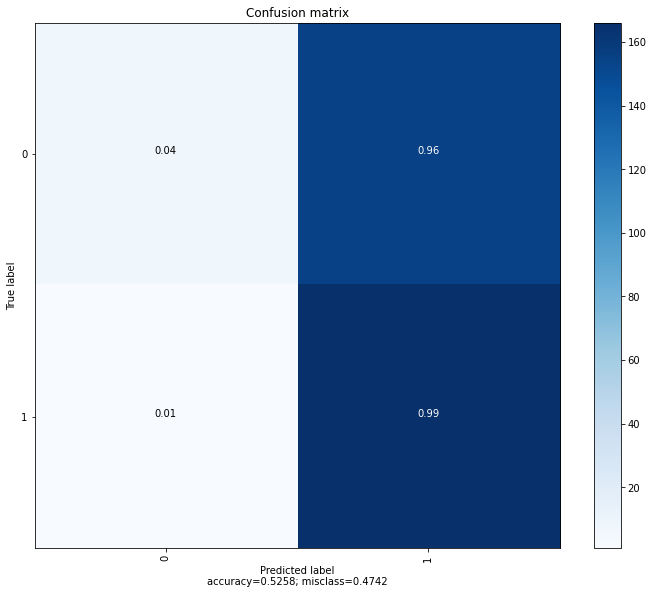

In [19]:
plot_confusion_matrix(test_labels, cat_pred.cpu(), [0, 1])